In [569]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import kerastuner
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from wandb.keras import WandbCallback
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [556]:
wandb.login()

True

# Priprava dat

In [26]:
data =  pd.read_csv('parkinsons.data', sep=",")

X = list(data.columns)
X.remove("name")
X.remove("status")
y = ["status"]

data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [206]:
data[X]

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,...,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [207]:
data[y]

,status
0,1
1,1
2,1
3,1
4,1
...,...
190,0
191,0
192,0
193,0


In [477]:
X_train, X_test, y_train, y_test = train_test_split(data[X], data[y], random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test[X], y_test[y], random_state=42)

In [475]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)
X_valid = min_max_scaler.fit_transform(X_valid)

In [305]:
# define sweep
sweep_config = {
  "name": "NN-test-sweep-keras",
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['Adam']
        },

    'criterion': {
        'values': ['binary_crossentropy']
        },

    'h1': {
        'values': [8, 16, 32, 64,256]
        },

    'h2': {
        'values': [8, 16, 32, 64,256]
        },

    'h3': {
        'values': [8, 16, 32, 64,256]
        },

    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        },

    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      },

    'epochs': {
        'distribution': 'int_uniform',
        'min':80,
        'max': 100,
        }
    }   

}

In [306]:
# initialize sweep
sweep_id = wandb.sweep(sweep_config) 

Create sweep with ID: 7p5zov1v
Sweep URL: https://wandb.ai/bombinko/uncategorized/sweeps/7p5zov1v


In [307]:
def train():
    with wandb.init(config=sweep_config):
    # Specify the other hyperparameters to the configuration
        config = wandb.config
        # Add the config item (layers) to wandb
        if wandb.run:
            # Define the model
            model = Sequential()
            model.add(Dense(config.h1, activation='relu'))
            model.add(Dense(config.h2, activation='relu'))
            model.add(Dense(config.h3, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss=config.criterion, optimizer=config.optimizer,metrics=['accuracy'])
            # Train the model
            model.fit(X_train, y_train, epochs=config.epochs,validation_data=(X_test, y_test),callbacks=[WandbCallback()],verbose=0)

In [ ]:
# run sweep
wandb.agent(sweep_id, function=train, count=5)


![title](img/tensor_loss.png)
![title](img/tensor_acc.png)

In [340]:
model3 = Sequential()

model3.add(Dense(32, activation='relu'))
model3.add(Dense(16, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='Adam',metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=87, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

2/2 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.75 - 0s 2ms/step - loss: 0.5279 - accuracy: 0.6944
Test accuracy: 0.6944444179534912


In [548]:
sweep_config = {
  "name": "NN-test-sweep1",
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['adam']
        },

    'criterion': {
        'values': ['binary_crossentropy']
        },

    'h1': {
        'values': [8, 16, 32, 64,256]
        },

    'h2': {
        'values': [8, 16, 32, 64,256]
        },

    'h3': {
        'values': [8, 16, 32, 64,256]
        },

    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        },

    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      },

    'epochs': {
        'values': [100,80]
        }
    }   

}

In [550]:
class Model(torch.nn.Module):
    def __init__(self, n_feature,h1, h2, h3):
        super(Model, self).__init__()
        self.input = torch.nn.Linear(n_feature, h1)
        self.hidden = [
            torch.nn.Linear(h1, h2),
            torch.nn.Linear(h2, h3)
        ]            
        self.output = torch.nn.Linear(h3, 1) 

    def forward(self, x):
        x = self.input(x)
        for h in self.hidden:
            x = F.relu(h(x))
        x = F.sigmoid(self.output(x))
        return x

        

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "adam":
        optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

def build_criterion(network, criterion):
    if criterion == "binary_crossentropy":
        criterion = torch.nn.BCELoss()

    return criterion

def train_epoch(network, actual, features, batch_size, optimizer, criterion):
    running_loss = 0.0
    batch_no = len(features) // batch_size
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = torch.Tensor(pd.DataFrame(features[start:end]).to_numpy())
        labels = torch.Tensor(pd.DataFrame(actual[start:end]).to_numpy())
        optimizer.zero_grad()

        outputs = network(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    acc = np.mean(np.float32(np.array(labels.data.flatten()) == np.array(outputs.data > 0.5, dtype=np.int8).flatten()))
    wandb.log({"acc": acc})
    return running_loss

In [551]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config

        network = Model(len(X), config.h1, config.h2, config.h3)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)
        criterion = build_criterion(network, config.criterion)
        
        for epoch in range(config.epochs):

            loss = train_epoch(network, values_y, X_train, config.batch_size, optimizer,criterion)
            wandb.log({"loss": loss, "epoch": epoch})

In [552]:
# initialize sweep
sweep_id = wandb.sweep(sweep_config) 

Create sweep with ID: vpy9p0o9
Sweep URL: https://wandb.ai/bombinko/uncategorized/sweeps/vpy9p0o9


In [553]:
# run sweep
wandb.agent(sweep_id, function=train, count=15)

wandb: Agent Starting Run: w7uzzcwv with config:
wandb: 	batch_size: 83
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 100
wandb: 	h1: 16
wandb: 	h2: 64
wandb: 	h3: 32
wandb: 	learning_rate: 0.028940638433370726
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.92771
_runtime,4
_timestamp,1616621094
_step,199
loss,0.2619
epoch,99


acc,▁▆▂▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: d937ovks with config:
wandb: 	batch_size: 58
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 100
wandb: 	h1: 8
wandb: 	h2: 8
wandb: 	h3: 16
wandb: 	learning_rate: 0.07755011802487544
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.72414
_runtime,5
_timestamp,1616621104
_step,199
loss,1.161
epoch,99


acc,▁▇▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ynl1b1d8 with config:
wandb: 	batch_size: 124
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 100
wandb: 	h1: 256
wandb: 	h2: 32
wandb: 	h3: 32
wandb: 	learning_rate: 0.08914257893692386
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.73387
_runtime,4
_timestamp,1616621112
_step,199
loss,26.6129
epoch,99


acc,▁███████████████████████████████████████
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nzjojbm2 with config:
wandb: 	batch_size: 78
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 80
wandb: 	h1: 16
wandb: 	h2: 256
wandb: 	h3: 256
wandb: 	learning_rate: 0.07064578805951262
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.75641
_runtime,4
_timestamp,1616621121
_step,159
loss,24.35897
epoch,79


acc,▁███████████████████████████████████████
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁███████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xo6w6zt1 with config:
wandb: 	batch_size: 102
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 80
wandb: 	h1: 8
wandb: 	h2: 256
wandb: 	h3: 256
wandb: 	learning_rate: 0.07040538454832014
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.7451
_runtime,4
_timestamp,1616621130
_step,159
loss,25.4902
epoch,79


acc,▁███████████████████████████████████████
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁███████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bnbe38r0 with config:
wandb: 	batch_size: 67
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 100
wandb: 	h1: 32
wandb: 	h2: 64
wandb: 	h3: 256
wandb: 	learning_rate: 0.06466284128909239
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.71642
_runtime,5
_timestamp,1616621140
_step,199
loss,52.23881
epoch,99


acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2dfcvx8r with config:
wandb: 	batch_size: 60
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 100
wandb: 	h1: 8
wandb: 	h2: 256
wandb: 	h3: 32
wandb: 	learning_rate: 0.0021312168141485177
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.78333
_runtime,4
_timestamp,1616621149
_step,199
loss,1.01928
epoch,99


acc,▁▂▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: osnt0yjd with config:
wandb: 	batch_size: 49
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 80
wandb: 	h1: 64
wandb: 	h2: 32
wandb: 	h3: 256
wandb: 	learning_rate: 0.0997673036626659
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.71429
_runtime,5
_timestamp,1616621159
_step,159
loss,53.06122
epoch,79


acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁█████████████████████████████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁█████████████████████████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁███████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: r0u6plzy with config:
wandb: 	batch_size: 39
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 100
wandb: 	h1: 32
wandb: 	h2: 16
wandb: 	h3: 16
wandb: 	learning_rate: 0.01374688377269353
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.76923
_runtime,5
_timestamp,1616621168
_step,199
loss,0.98618
epoch,99


acc,▁▁▁▁▁▁▁▁▁▇▇▇▇█████████████████▇████▇███▇
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 351co05d with config:
wandb: 	batch_size: 148
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 80
wandb: 	h1: 64
wandb: 	h2: 256
wandb: 	h3: 32
wandb: 	learning_rate: 0.0077622019535282475
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Run 351co05d errored: UnboundLocalError("local variable 'labels' referenced before assignment")
wandb: ERROR Run 351co05d errored: UnboundLocalError("local variable 'labels' referenced before assignment")
wandb: Agent Starting Run: 9wwhd8jc with config:
wandb: 	batch_size: 126
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 100
wandb: 	h1: 32
wandb: 	h2: 64
wandb: 	h3: 64
wandb: 	learning_rate: 0.020270025672564862
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.86508
_runtime,5
_timestamp,1616621185
_step,199
loss,0.35208
epoch,99


acc,▁▆▆▆▆▆▆▆▆▇▆▇▆▇▇▇▇▇▇▆▇▇▇▇▇▇██▇██▇█▇▇█▇█▇█
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▆█▄▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: e3fmqlod with config:
wandb: 	batch_size: 162
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 100
wandb: 	h1: 32
wandb: 	h2: 32
wandb: 	h3: 256
wandb: 	learning_rate: 0.043907707474729885
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Run e3fmqlod errored: UnboundLocalError("local variable 'labels' referenced before assignment")
wandb: ERROR Run e3fmqlod errored: UnboundLocalError("local variable 'labels' referenced before assignment")
wandb: Agent Starting Run: rce5q7l9 with config:
wandb: 	batch_size: 138
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 80
wandb: 	h1: 256
wandb: 	h2: 16
wandb: 	h3: 32
wandb: 	learning_rate: 0.042953877463858085
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.73913
_runtime,5
_timestamp,1616621205
_step,159
loss,0.57831
epoch,79


acc,██▁█▁██▆████████████████████████████████
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▂▅▇▇█▄▂▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: x0du4c2z with config:
wandb: 	batch_size: 47
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 100
wandb: 	h1: 8
wandb: 	h2: 32
wandb: 	h3: 16
wandb: 	learning_rate: 0.06088447699298876
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


acc,0.80851
_runtime,5
_timestamp,1616621217
_step,199
loss,0.91029
epoch,99


acc,▁▆▁▃▆▆▆▆█▆▆█▃▆██▆█▆▆▆▆▆▆▆▆▁▃▅▁▆█▃█▅▆█▆██
_runtime,▁███████████████████████████████████████
_timestamp,▁███████████████████████████████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▃▂▂▁▁▂▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: a0oxwkbz with config:
wandb: 	batch_size: 158
wandb: 	criterion: binary_crossentropy
wandb: 	epochs: 100
wandb: 	h1: 16
wandb: 	h2: 256
wandb: 	h3: 64
wandb: 	learning_rate: 0.09746933324733977
wandb: 	optimizer: adam
Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: wandb version 0.10.23 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Run a0oxwkbz errored: UnboundLocalError("local variable 'labels' referenced before assignment")
wandb: ERROR Run a0oxwkbz errored: UnboundLocalError("local variable 'labels' referenced before assignment")


![title](img/torch_loss.png)
![title](img/torch_acc.png)

In [587]:
# wandb.init()
network = Model(len(X),4, 16, 16)
optimizer = build_optimizer(network, "adam",  0.07941)
criterion = build_criterion(network, "binary_crossentropy")

for epoch in range(80):
    train_epoch(network, values_y, X_train, 39, optimizer,criterion)

In [609]:
values_y = y_train.values
pyPred = torch.Tensor(pd.DataFrame(X_valid).to_numpy())
result = network(pyPred)

pytorch_prediction=result.data.numpy()
tensorflow_prediction = model.predict(X_valid)

C:\Users\marti\anaconda3\envs\NN_2\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


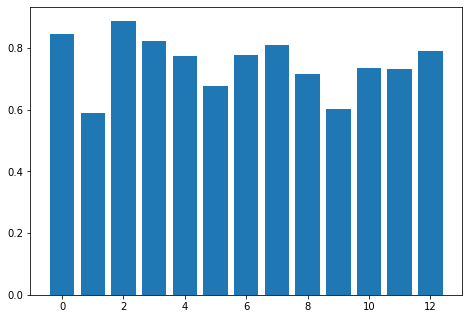

In [611]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = range(13)
students = tensorflow_prediction[:,0]
ax.bar(langs,students)
plt.show()

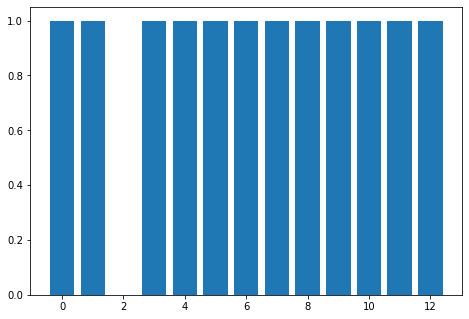

In [592]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = range(13)
students = y_valid['status']
ax.bar(langs,students)
plt.show()

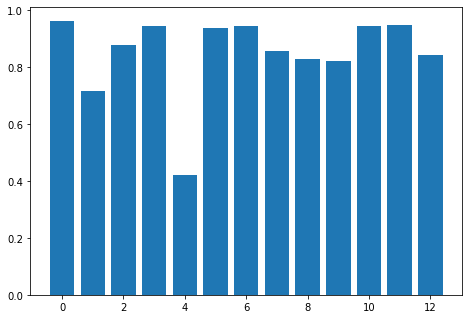

In [593]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = range(13)
students = pytorch_prediction[:,0]
ax.bar(langs,students)
plt.show()

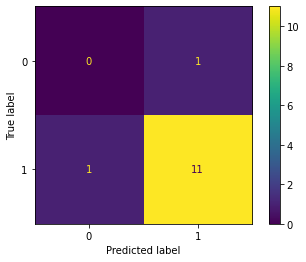

In [606]:
py_predict_norm = (pytorch_prediction>0.5)
cm = confusion_matrix(y_valid['status'], py_predict_norm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

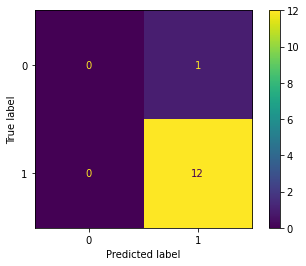

In [612]:
tf_predict_norm = (tensorflow_prediction>0.5)
cm = confusion_matrix(y_valid['status'], tf_predict_norm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

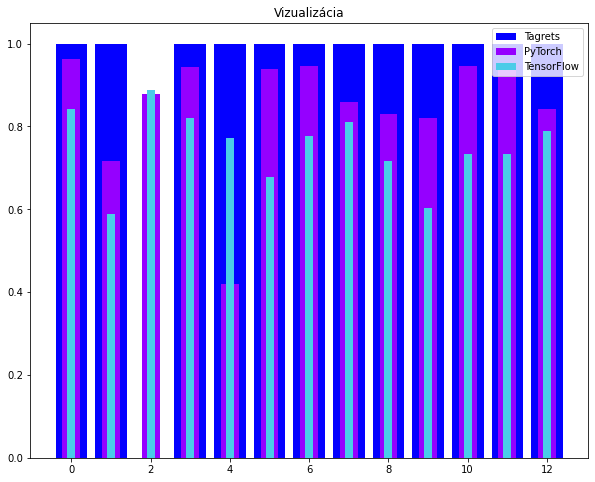

In [613]:
sample_size = 13
plt.figure(figsize=(10, 8))
plt.bar(range(sample_size),y_valid['status'][:sample_size],color="#0400ff",label="Tagrets")
plt.bar(range(sample_size),pytorch_prediction[:,0][:sample_size],color="#9500ff", width=0.45, label='PyTorch')
plt.bar(range(sample_size),tensorflow_prediction[:,0][:sample_size],color="#4acce8", width=0.2,label="TensorFlow")

plt.legend(loc="upper right")
plt.title("Vizualizácia")
plt.show()